# Recommender System - Latent Factor Model

* Approach - Latent Factor Model
* Cost Function Optimization - Stochastic Gradient Descent
* Reference: [CS 550 Lecture Series, Week 6: Recommender Systems - Part 9 Extension of Latent Factor Models](https://www.youtube.com/watch?v=Olk1aR8dVho&list=PLLBN4Z0UI9IfiSlMk923dcnje0BYfhivd&index=37)


---
## Outline
* Read the Dataset
* Pre-Process Data, Generate Matrix (R)
* Intialize P,Q (R = P * Q)
* Minimize the Cost Function and Gradient Descent
* The MSE - Epoch Plot
* The Prediction Result - Complete Matrix

In [1]:
# import package
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Read the Dataset

In [2]:
# read df for rating
movie_df_path='../input/movierecommenderdataset/ratings.csv'
data=pd.read_csv(movie_df_path)
data.rename(columns={"userId": "user_id", "movieId": "item_id"},inplace=True)

# read the item_id to movie title data
item_title=pd.read_csv('../input/movierecommenderdataset/movies.csv')
item_title['movieId'] = item_title['movieId'].astype('str')
item_title.rename(columns={"movieId": "item_id"},inplace=True)

# Pre-Process the Dataset, Generate Matrix

In [3]:
# pre-process data 
data.drop('timestamp',axis=1,inplace=True)
data['user_id'] = data['user_id'].astype('str')
data['item_id'] = data['item_id'].astype('str')

# generate the matrix
matrix_df = data.pivot_table(index='user_id',columns='item_id',values='rating')
# only keep the popular movies (simplify the dataset)
perc = 65.0 # Like N %
min_count =  int(((100-perc)/100)*matrix_df.shape[0] + 1)
matrix_df = matrix_df.dropna( axis=1, 
                thresh=min_count)

# rename the column header 
item_list=list(matrix_df.columns)
item_name_list=[]
for item_id in item_list:
  item_name=(item_title[item_title['item_id']==item_id]['title'].values[0])
  item_name_list.append(item_name)
item_name_list
# replace the item_id with movie name
matrix_df.set_axis(item_name_list, axis=1,inplace=True)


# fill the NaN with 0
matrix = matrix_df.fillna(0).values

# look into the shape of matrix
display(matrix_df)

,Toy Story (1995),Braveheart (1995),"Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Fight Club (1999),Pulp Fiction (1994),"Shawshank Redemption, The (1994)",Forrest Gump (1994),Jurassic Park (1993),Schindler's List (1993),Terminator 2: Judgment Day (1991),"Silence of the Lambs, The (1991)"
user_id,,,,,,,,,,,,
1,4.0,4.0,5.0,5.0,5.0,3.0,NaN,4.0,4.0,5.0,NaN,4.0
10,NaN,NaN,0.5,NaN,0.5,1.0,NaN,3.5,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,3.5,NaN,4.0,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,5.0,4.0,5.0,3.0,NaN,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,3.5,NaN,4.0,NaN
96,5.0,5.0,4.0,5.0,NaN,5.0,NaN,NaN,5.0,5.0,5.0,NaN
97,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


# The Latent Factor Model

![link text](https://i.ytimg.com/vi/FKOGrTprUXU/maxresdefault.jpg)

So, Our Matrix = R , and:

* R = m * n Matrix
  * m = # of users
  * n = # of items

* $R=P ⋅ Q^{T} $
  * $P = row-wised =dimension(m·r)$ 
  * $Q^{T} = column-wised =dimension(r·n)$ 
    * P = dimension(n.r)
  * r = num of Latent Factors Chosen

* To Avoid Overfitting, we use L2 Regularization 
  * $λ = regularization factor$


* So, The Cost Function = MSE + $λ · L2_{norm}$

---

## Stochastic Gradient Descent (Minimize the Cost Function)
* Optimization = Gradient Descent ($α$ = learning rate) Update $p_u, q_i$ (for $r_{ui}$ ! = 0)
  * The Gradient Descent per Iteration (Only Update for Non-Zero Value in Matrix R)
  * For each Epoch:
    * --- Update $p_u \leftarrow p_u + α \cdot [q_i (r_{ui} - p_u \cdot q_i) - λ\cdot p_u]$
    * --- Update $q_i \leftarrow q_i + α \cdot [p_u (r_{ui} - p_u \cdot q_i) - λ\cdot q_i]$
  * Meaning of $p_u, q_i$:
    * $p_u$ = row u of P
    * $q_i$ = row i of Q

# Intialize Matrix P, Q

In [4]:
# extract the non-zero index for matrix
## np.nonzero() = Return the indices of the elements that are non-zero.
users, items=matrix.nonzero()
m, n = matrix.shape

# set the hyperparameters
X_train=matrix

n_latent_features=4
# initialize P and Q 
P = np.random.rand(m,n_latent_features)
Q = np.random.rand(n,n_latent_features)

In [5]:
# look into the shape of P and Q
print(P.shape)
print(Q.shape)

(610, 4)
(12, 4)


## Stochastic Gradient Descent (Minimize the Cost Function)
  * The Gradient Descent per Iteration (Only Update for Non-Zero Value in Matrix R)
  * For each Epoch:
    * --- Update $p_u \leftarrow p_u + α \cdot [q_i (r_{ui} - p_u \cdot q_i) - λ\cdot p_u]$
    * --- Update $q_i \leftarrow q_i + α \cdot [p_u (r_{ui} - p_u \cdot q_i) - λ\cdot q_i]$
  * Meaning of $p_u, q_i$:
    * $p_u$ = row u of P
    * $q_i$ = row i of Q

## The MSE

In [6]:
# func for predictions
def predictions(P, Q):
    return P@Q.T

# func to calculate the rmse
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)



## The Gradient Descent per Iteration (Only Update for Non-Zero Value in Matrix R)
### For each Epoch:

### --- Update $p_u$
  * $p_u \leftarrow p_u + α \cdot [q_i (r_{ui} - p_u \cdot q_i) - λ\cdot p_u]$

### --- Update $q_i$
  * $q_i \leftarrow q_i + α \cdot [p_u (r_{ui} - p_u \cdot q_i) - λ\cdot q_i]$

In [7]:
# Run the Grad Des for P,Q Updating
def grad_des_train(n_epochs,lmbda,learning_rate):
  train_error = []
  for epoch in range(n_epochs):
    for u, i in zip(users, items):
        error = X_train[u, i] - np.dot(P[u, :], Q[i, :])
        P[u, :] = P[u, :] + learning_rate * (error * Q[i, :] - lmbda * P[u, :])
        Q[i, :] = Q[i, :] + learning_rate * (error * P[u, :] - lmbda * Q[i, :] )

    train_mse = mse(predictions(P,Q), X_train)
    train_error.append(train_mse)
  return P,Q,train_error

In [8]:
# Run the Stochastic Gradient Descent
P,Q,train_error=grad_des_train(n_epochs=100,lmbda=0.1,learning_rate=0.005)

# Plot the Error - Epoch Graph

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


The Final MSE = 0.4356296421879666


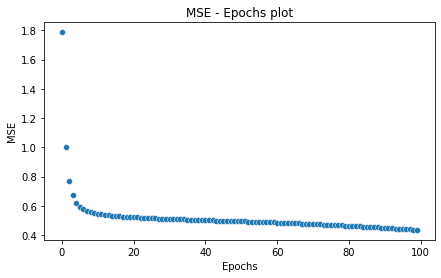

In [9]:
# plot the rmse vs epoch
def plot_rmse_epoch(): 
  x=range(len(train_error))
  y=train_error
  # graph
  fig,ax1=plt.subplots(1,1,figsize=(7,4))
  sns.scatterplot(x,y,ax=ax1)
  ax1.set_title('MSE - Epochs plot')
  ax1.set(xlabel='Epochs',ylabel='MSE')

  # the final mse
  final_mse=min(train_error)
  print(f'The Final MSE = {final_mse}')
  return final_mse

# plot
final_mse=plot_rmse_epoch()

# The Prediction Result - The Completed Matrix

In [10]:
# display the prediction matrix result
def pred_result():
  prediction_matrix=predictions(P,Q)
  prediction_matrix_df=matrix_df.copy()
  prediction_matrix_df[:]=prediction_matrix
  # combine the prediction and original matrix (replace the prediction rate with some existing rate )
  for row,col in zip(users, items):
    prediction_matrix_df.iloc[row,col]=matrix[row,col]
  return prediction_matrix_df

In [11]:
# The Prediction matrix result
prediction_matrix_df=pred_result()
prediction_matrix_df

,Toy Story (1995),Braveheart (1995),"Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Fight Club (1999),Pulp Fiction (1994),"Shawshank Redemption, The (1994)",Forrest Gump (1994),Jurassic Park (1993),Schindler's List (1993),Terminator 2: Judgment Day (1991),"Silence of the Lambs, The (1991)"
user_id,,,,,,,,,,,,
1,4.000000,4.000000,5.000000,5.000000,5.000000,3.000000,4.342166,4.000000,4.000000,5.000000,4.100341,4.000000
10,1.006832,1.696566,0.500000,1.200660,0.500000,1.000000,1.395424,3.500000,1.445610,1.528791,1.499069,1.227528
100,3.243694,3.583613,3.671927,3.699505,3.715648,3.500000,3.801016,4.000000,3.326079,3.676825,3.480213,3.664013
101,4.194079,4.210485,4.532715,4.705753,5.000000,4.521948,4.689284,4.273309,4.043869,4.436627,4.226420,4.615821
102,3.662883,3.933885,4.281477,4.207747,4.365928,5.000000,4.000000,5.000000,3.000000,4.241009,4.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.037001,4.147769,5.000000,5.000000,4.512174,4.450404,4.490177,4.177834,3.500000,4.460116,4.000000,4.345358
96,5.000000,5.000000,4.000000,5.000000,4.927881,5.000000,5.172830,4.816222,5.000000,5.000000,5.000000,5.045808
97,4.180261,4.402660,5.000000,4.788417,4.927714,4.983075,4.941538,4.464230,4.014737,4.758215,4.244207,5.000000


# For Specific User_id, Generate Movie Rate Prediction

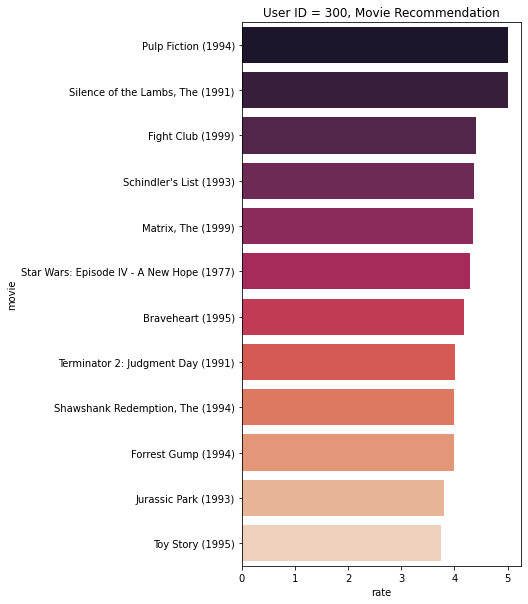

In [12]:
# input = user_id, output =  Recommend Movie
def recommend_by_user(user_id):
  user_rate=prediction_matrix_df.iloc[user_id,:].to_frame(name='rate')
  user_rate['movie'] = user_rate.index
  user_rate.sort_values(by=['rate'],ascending=False,inplace=True)
  user_rate.reset_index(drop=True,inplace=True)
  # plot
  fig,ax1=plt.subplots(1,1,figsize=(5,10))
  sns.barplot(data=user_rate,y='movie',x='rate',palette="rocket",ax=ax1)
  ax1.set_title(f'User ID = {user_id}, Movie Recommendation')
  return user_rate

# run the func
user_rate=recommend_by_user(user_id=300)